In [70]:
import string 
import re 
from numpy import array, argmax, random, take
import pandas as pd 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed 
from keras.preprocessing.text import Tokenizer 
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing. sequence import pad_sequences 
from keras.models import load_model 
from keras import optimizers 
import matplotlib.pyplot as plt 
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)


imported necessary packages

reading file using function

In [47]:
# function to read raw text file 
def read_text(filename): 
# open the file 
    file = open(filename, mode='rt', encoding='utf-8') 
# read all text 
    text = file.read() 
    file.close() 
    return text

splitting text into english german pairs seperated by '\n' and then split these pairs into english sentences and german sentences

In [94]:
#split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents
    

In [49]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

actual data contains over 150000 sentence pairs,to reduce training time of model we are going to use 25000 sentence pairs

In [52]:
deu_eng = deu_eng[:25000,:]

In [53]:
#lets take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom shot a bear.', 'Tom hat einen Bären erschossen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2799074 (AlanF_US) & #2477658 (Pfirsichbaeumchen)'],
       ['Tom should come.', 'Tom sollte kommen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2237751 (CK) & #4823013 (MisterTrouser)'],
       ['Tom should know.', 'Tom weiß es sicher.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2237754 (CK) & #6557528 (raggione)']],
      dtype='<U537')

Text to sequence conversion
to feed our data in seq2seq model encoder decoder we will have to convert both input and output sentences into 'integer sequences' of fixed length.
before that to visualise the length of the sentences ,we will capture length of all sentences in 2 seperate lists for english and german respectively

In [54]:
# empty lists 
eng_1 = [] 
deu_1 = [] 
# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
     eng_1.append(len(i.split()))
for i in deu_eng[:,1]: 
     deu_1.append(len(i.split()))

In [55]:
length_df = pd.DataFrame({'eng':eng_1,'deu':deu_1})

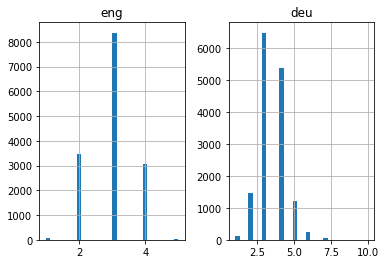

In [56]:
length_df.hist(bins = 30)
plt.show()

The maximum length of German sentences is 11 and that of the English phrases is 8 . 
so lets vectorize our text data using Keras's Tokenizer() class.It will turn our sentences into sequences of integers.then we will pad those integers with zeroes to make all sequences of same length

In [57]:
# function to build a tokenizer 
def tokenization(lines):
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [68]:
# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[ :, 0])               
eng_vocab_size= len(eng_tokenizer.word_index) + 1 
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3000


In [69]:
# prepare deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[ :, 1])               
deu_vocab_size= len(deu_tokenizer.word_index) + 1 
deu_length = 8
print('deutch Vocabulary Size: %d' % deu_vocab_size)

deutch Vocabulary Size: 4731


function to prepare sequences,it will also perform sequence padding to maximum sentence length as mentioned above

In [60]:
# encode and pad sequences 
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences 
    seq = tokenizer.texts_to_sequences(lines) 
    # pad sequences with 0 values 
    seq = pad_sequences(seq, maxlen=length, padding='post') 
    return seq

MODEL BUILDING

we will now split the data into train and test set for model training and evaluation

In [61]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Its time to encode sentences,we will encode german sentences as input sequences and english sentences as target sequences.it will be done for both train and test datasets

In [62]:
# prepare training data 
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1]) 
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [63]:
 # prepare validation data 
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1]) 
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0]) 

Most important part

We are using an Embedding Layer and an LSTM layer as our encoder and another LSTM layer followed by a dense layer as decoder 

In [64]:
# build NMT model 
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units): 
    model = Sequential() 
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True)) 
    model.add(Dense(out_vocab, activation='softmax')) 
    return model



We are using RMSprop optimizer for this model as it is very good for recurrent neural network(RNN)

In [79]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

we have used 'sparse_categorical_crossentropy' as loss function because it allows us to use the target sequences as it is instead of one hot encoded format .One hot encoding the target sequences with such a huge vocabulary that it may consume whole system memory
.We will train it for 30 epochs and with a batch size of 512.we will use ModelCheckPoint() to save the best model with lowest validation loss.this is best method over early stopping 

In [67]:
filename = 'model.hl.24_harshitha' 
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                     epochs=30, batch_size=512, 
                     validation_split = 0.2, 
                     callbacks=[checkpoint], verbose=1)

Epoch 1/30
19/19 [==============================] - 47s 2s/step - loss: 3.3122 - val_loss: 2.5049

Epoch 00001: val_loss improved from inf to 2.50488, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 2/30
19/19 [==============================] - 45s 2s/step - loss: 2.3495 - val_loss: 2.2475

Epoch 00002: val_loss improved from 2.50488 to 2.24745, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 3/30
19/19 [==============================] - 45s 2s/step - loss: 2.1920 - val_loss: 2.2154

Epoch 00003: val_loss improved from 2.24745 to 2.21542, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 4/30
19/19 [==============================] - 45s 2s/step - loss: 2.1227 - val_loss: 2.1734

Epoch 00004: val_loss improved from 2.21542 to 2.17337, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 5/30
19/19 [==============================] - 45s 2s/step - loss: 2.0899 - val_loss: 2.1630

Epoch 00005: val_loss improved from 2.17337 to 2.16301, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 6/30
19/19 [==============================] - 45s 2s/step - loss: 2.0466 - val_loss: 2.1526

Epoch 00006: val_loss improved from 2.16301 to 2.15261, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 7/30
19/19 [==============================] - 45s 2s/step - loss: 1.9789 - val_loss: 2.0895

Epoch 00007: val_loss improved from 2.15261 to 2.08948, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 8/30
19/19 [==============================] - 44s 2s/step - loss: 1.9080 - val_loss: 2.0007

Epoch 00008: val_loss improved from 2.08948 to 2.00070, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 9/30
19/19 [==============================] - 44s 2s/step - loss: 1.8284 - val_loss: 2.0096

Epoch 00009: val_loss did not improve from 2.00070
Epoch 10/30
19/19 [==============================] - 44s 2s/step - loss: 1.7688 - val_loss: 1.9331

Epoch 00010: val_loss improved from 2.00070 to 1.93306, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 11/30
19/19 [==============================] - 44s 2s/step - loss: 1.7063 - val_loss: 1.8957

Epoch 00011: val_loss improved from 1.93306 to 1.89573, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 12/30
19/19 [==============================] - 45s 2s/step - loss: 1.6509 - val_loss: 1.8789

Epoch 00012: val_loss improved from 1.89573 to 1.87888, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 13/30
19/19 [==============================] - 45s 2s/step - loss: 1.6037 - val_loss: 1.8378

Epoch 00013: val_loss improved from 1.87888 to 1.83779, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 14/30
19/19 [==============================] - 45s 2s/step - loss: 1.5541 - val_loss: 1.8159

Epoch 00014: val_loss improved from 1.83779 to 1.81588, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 15/30
19/19 [==============================] - 44s 2s/step - loss: 1.5022 - val_loss: 1.7977

Epoch 00015: val_loss improved from 1.81588 to 1.79773, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 16/30
19/19 [==============================] - 45s 2s/step - loss: 1.4537 - val_loss: 1.7673

Epoch 00016: val_loss improved from 1.79773 to 1.76732, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 17/30
19/19 [==============================] - 45s 2s/step - loss: 1.4012 - val_loss: 1.7451

Epoch 00017: val_loss improved from 1.76732 to 1.74510, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 18/30
19/19 [==============================] - 46s 2s/step - loss: 1.3564 - val_loss: 1.7172

Epoch 00018: val_loss improved from 1.74510 to 1.71716, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 19/30
19/19 [==============================] - 45s 2s/step - loss: 1.3108 - val_loss: 1.7030

Epoch 00019: val_loss improved from 1.71716 to 1.70303, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 20/30
19/19 [==============================] - 45s 2s/step - loss: 1.2622 - val_loss: 1.6978

Epoch 00020: val_loss improved from 1.70303 to 1.69777, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 21/30
19/19 [==============================] - 45s 2s/step - loss: 1.2233 - val_loss: 1.6531

Epoch 00021: val_loss improved from 1.69777 to 1.65307, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 22/30
19/19 [==============================] - 45s 2s/step - loss: 1.1799 - val_loss: 1.6423

Epoch 00022: val_loss improved from 1.65307 to 1.64235, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 23/30
19/19 [==============================] - 45s 2s/step - loss: 1.1432 - val_loss: 1.6289

Epoch 00023: val_loss improved from 1.64235 to 1.62891, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 24/30
19/19 [==============================] - 45s 2s/step - loss: 1.0977 - val_loss: 1.6310

Epoch 00024: val_loss did not improve from 1.62891
Epoch 25/30
19/19 [==============================] - 45s 2s/step - loss: 1.0632 - val_loss: 1.6034

Epoch 00025: val_loss improved from 1.62891 to 1.60345, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 26/30
19/19 [==============================] - 45s 2s/step - loss: 1.0314 - val_loss: 1.6056

Epoch 00026: val_loss did not improve from 1.60345
Epoch 27/30
19/19 [==============================] - 44s 2s/step - loss: 0.9942 - val_loss: 1.5779

Epoch 00027: val_loss improved from 1.60345 to 1.57788, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 28/30
19/19 [==============================] - 44s 2s/step - loss: 0.9606 - val_loss: 1.5528

Epoch 00028: val_loss improved from 1.57788 to 1.55276, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 29/30
19/19 [==============================] - 45s 2s/step - loss: 0.9239 - val_loss: 1.5412

Epoch 00029: val_loss improved from 1.55276 to 1.54115, saving model to model.hl.24_harshitha


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


INFO:tensorflow:Assets written to: model.hl.24_harshitha/assets


Epoch 30/30
19/19 [==============================] - 44s 2s/step - loss: 0.8911 - val_loss: 1.5547

Epoch 00030: val_loss did not improve from 1.54115


lets compare the training loss and the validation loss

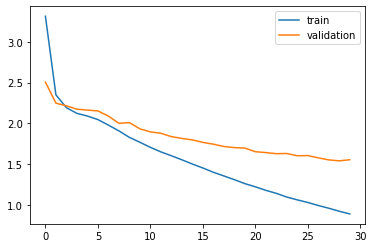

In [71]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.legend(['train', 'validation']) 
plt.show()

Lets load the saved model to make predictions

In [86]:
model = load_model('model.hl.24_harshitha/')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [73]:
def get_word(n, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == n: 
           return word
    return None

In [100]:
#convert predictions into text (English)
preds_text = [] 
for i in preds: 
    temp = [ ] 
    for j in range(len(i)): 
        t = get_word(i[j], eng_tokenizer) 
        if j > 0: 
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None): 
              temp.append(' ') 
            else:
              temp.append(t)
        else:
            if (t == None):
               temp.append(' ') 
            else: 
               temp.append(t) 
    preds_text.append(' '.join(temp))  

In [101]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [102]:
 pd.set_option('display.max_colwidth', 200) 

checking first 15 sentences actual and predicted

In [103]:
pred_df.head(15)

,actual,predicted
0,I like rice.,i like coffee
1,I'll check that.,i'll be it
2,Tom's strict.,tom is
3,I'm too young.,i'm not
4,It's water.,it's is water
5,He was invited.,he was
6,Here she comes.,come in here
7,I freaked out.,i'm am
8,Be objective.,it's everything
9,Dinner is ready.,it's is


checking last 15 sentences

In [104]:
pred_df.tail(15)

,actual,predicted
2985,Listen to this!,we'll go it
2986,This one's mine.,it's mine
2987,Tom was dead.,tom was in
2988,Tom slapped me.,tom didn't me
2989,I can't help it.,i can't talk
2990,Tom sat quietly.,tom will us
2991,It makes sense.,it's it
2992,I hate winter.,i hate my
2993,Is that a dog?,is that a cat
2994,I recovered.,i prefer


In [106]:
pred_df.head(100)

,actual,predicted
0,I like rice.,i like coffee
1,I'll check that.,i'll be it
2,Tom's strict.,tom is
3,I'm too young.,i'm not
4,It's water.,it's is water
...,...,...
95,Is this a dream?,is it a joke
96,Tom is lost.,tom will
97,Are you OK?,are you well
98,I'm catching on.,i get
